This tutorial will demonstrate how to pre-process single-cell raw UMI counts to generate expression matrices that can be used as input to cell-cell communication tools. We will assume appropriate quality-control (QC) has already been applied to the dataset (e.g., exclusion of low-quality cells and doublets). We recommend the tutorial by [Luecken & Theis](https://doi.org/10.15252/msb.20188746) as a starting point for a detailed overview of QC and single-cell RNAseq analysis pipelines in general. 

Here we will focus on:
1. Normalization
2. Inter-operability between R and python. 

We demonstrate a typical workflow using the popular single-cell analysis software [scanpy](https://scanpy.readthedocs.io/en/stable/) to generate an AnnData object which can be used downstream. We will use a [BALF COVID dataset](https://doi.org/10.1038/s41591-020-0901-9), which contains 12 samples associated with "Healthy Control", "Moderate", or "Severe" COVID contexts.

Details and caveats regarding [batch correction](https://www.nature.com/articles/s41592-018-0254-1), which removes technical variation while preserving biological variation between samples, can be viewed in the additional examples tutorial entitled "S1_Batch_Correction".

In [ ]:
import os
import pickle

import scanpy as sc
import pandas as pd
import numpy as np

import sys
sys.path.insert(1, '/home/hratch/Projects/CCC/ccc_protocols/scripts/') # replace with cell2cell
from cell2cell_dev.datasets.load_data import CovidBalf

import warnings
warnings.filterwarnings('ignore')

seed = 888

data_path = '/data3/hratch/ccc_protocols/'

The 12 samples can be downloaded as .h5 files from [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE145926). You can also download the cell metadata from [here](https://raw.githubusercontent.com/zhangzlab/covid_balf/master/all.cell.annotation.meta.txt)

cell2cell has a helper function to download and format the raw UMI counts and metadata:

In [ ]:
covid_balf_data = CovidBalf(data_path = os.path.join(data_path, 'raw/covid_balf/'))
# covid_balf_data.download_data()
md, balf_samples = covid_balf_data.format_data()

md.head()

balf_samples is a dictionary with keys as each sample and values as an AnnData object storing the raw UMI counts for that sample

In [ ]:
balf_samples.keys()

In [ ]:
balf_samples['C100']

To normalize the raw UMI counts, we recommend log(1+CPM) normalization, as this maintains non-negative counts and is the input for many communication scoring functions

In [ ]:
for adata in balf_samples.values():
    adata.raw = adata # store the raw UMI counts (note this is actually typically used to store normalized counts)
    sc.pp.normalize_total(adata, target_sum=1e6) # CPM normalize
    sc.pp.log1p(adata) # logarithmize

In [ ]:
balf_samples['C100']

In [ ]:
ordered_genes = sorted(balf_samples['C100'].to_df().T.index)
balf_samples['C100'].to_df().T.loc[ordered_genes,:].head()

We can save this diction for future use in other scripts:

In [ ]:
with open(os.path.join(data_path, 'interim/covid_balf_norm.pickle'), 'wb') as handle:
    pickle.dump(balf_samples, handle, protocol=pickle.HIGHEST_PROTOCOL) # when we rewrite this part, let's better use the h5ad format, pickle is just horrible from my experience

## Preparare the object for cell-cell communication analysis

Here, I just do the basic processing as it makes sense to me to be seperate from the scoring function chapter

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

import cell2cell as c2c

In [2]:
# Reload adata object
adata = c2c.datasets.balf_covid()

#### Basic Filtering

In [3]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [4]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

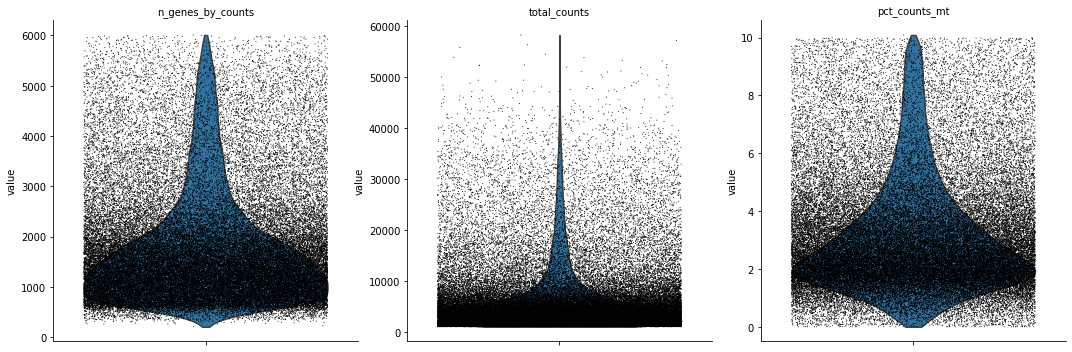

In [5]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

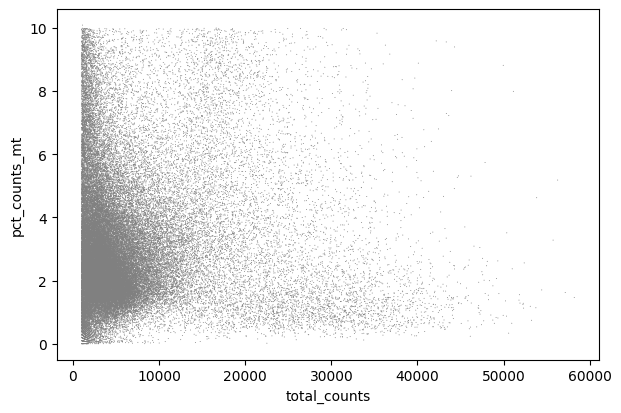

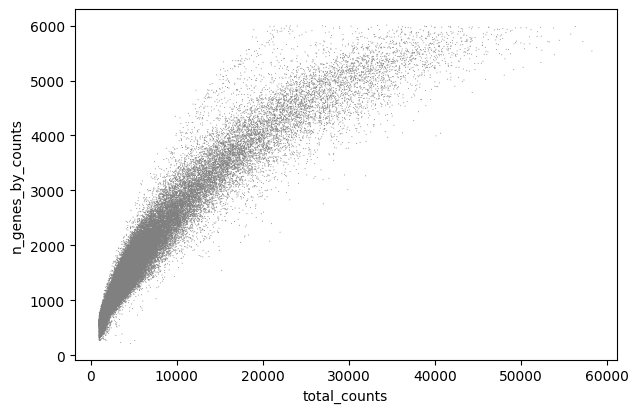

In [6]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [7]:
adata = adata[adata.obs.n_genes_by_counts < 5500, :]
adata = adata[adata.obs.pct_counts_mt < 15, :]

#### Normalize

For single-cell inference across sample and across cell types, we require the library sizes to be comparable. We can use the scanpy function `sc.pp.normalize_total` to normalize the library sizes. This function divides each cell by the total counts per cell and multiplies by the median of the total counts per cell. Furthermore, we log1p-transform the data to make it more Gaussian-like, as this is a common assumption for the analyses downstream.

In [8]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata.copy() # copy the normalized data to adata.layers["logcounts"]

/home/dbdimitrov/anaconda3/envs/cell2cell/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


#### Find Variable features

In [9]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

#### Dimensionality Reduction

/home/dbdimitrov/anaconda3/envs/cell2cell/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


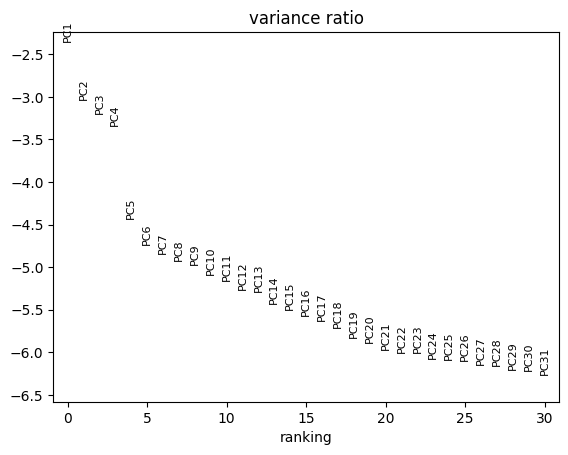

In [10]:
# pca
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [11]:
# neighbors
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
# umap
sc.tl.umap(adata)

Of course, would be better to replot the UMAP with integrated data :) - I just needed the normalized counts for the second chapter :)

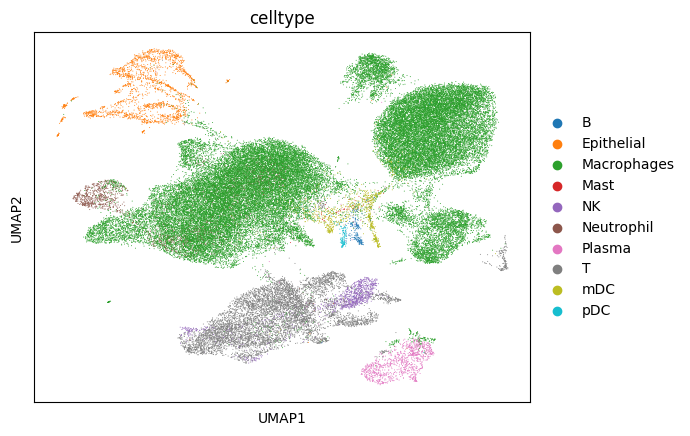

In [12]:
# plot pre-annotated cell types
sc.pl.umap(adata, color=['celltype']) ###

Save the data for downsteam analysis

In [13]:
adata.write_h5ad('../../data/processed.h5ad')

# Interoperability

## to R

For use in R, we can save each AnnData object, and then load it in R as a SeuratObject using [SeuratDisk](https://mojaveazure.github.io/seurat-disk/articles/convert-anndata.html). See the companion R tutorial for loading these saved files. 

In [ ]:
for sample in balf_samples:
    file_name = os.path.join(data_path, 'interim/covid_python_to_R/', sample + '.h5ad')
    adata = balf_samples[sample]
    adata.write_h5ad(file_name)

## from R

Here, we can load the expression matrices that were generated in the companion R script using Seurat and saved as h5ad files:

In [ ]:
balf_samples_R = dict()
for sample in balf_samples:
    file_name = os.path.join(data_path, 'interim/covid_R_to_python/', sample + '.h5ad')
    balf_samples_R[sample] = sc.read_h5ad(file_name)

While this AnnData object is not completely identical to the one generated in this script, it stores all the same information. Raw UMI counts are stored in the .raw attribute, relevant metadata is available in .obsm, and the log(1+CPM) matrix is stored in .X. We can see that the expression matrix is the same:

In [ ]:
balf_samples_R['C100']

In [ ]:
ordered_genes = sorted(balf_samples_R['C100'].to_df().T.index)
balf_samples_R['C100'].to_df().T.loc[ordered_genes,:].head()